In [1]:
!pip install -q pyspark

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 199 kB 47.2 MB/s 


In [2]:
!pip install -q findspark

In [3]:
## Databricks notebook source
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.multiprocessing import cpu_count
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import normalize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from joblib import load, dump
import findspark
from pyspark.sql.functions import col, explode
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
# Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Create a Spark session to be able to analyze individual recognition model results
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder\
                    .master('local')\
                    .appName('Colab')\
                    .config('spark.ui.port', '4050')\
                    .getOrCreate()

In [6]:
# Load the embeddings from the previously trained SimCLR model into a new resnet model for inference
resnet18_new = torchvision.models.resnet18()
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1])
ckpt = torch.load('/content/drive/My Drive/individual_rec_models/individ_rec_modelsandhelpers/simclrresnet18embed.pth')
backbone_new.load_state_dict(ckpt['resnet18_parameters'])

<All keys matched successfully>

In [7]:
# Get the full image paths for the training dataset for the individual hyenas, leopards, and giraffes
hyena_train_paths = glob.glob('/content/drive/My Drive/hyena.coco/processed/train/*/*')
leopard_train_paths = glob.glob('/content/drive/My Drive/leopard.coco/processed/train/*/*')
giraffe_train_paths = glob.glob('/content/drive/My Drive/great_zebra_giraffe/individual_recognition/train/*/*')

In [8]:
# For each species, make dataframes of the training counts of individual animals
hyena_train_df = pd.DataFrame({'image_path': hyena_train_paths, 'animal_id': [x.split('/')[-2] for x in hyena_train_paths]})
leopard_train_df = pd.DataFrame({'image_path': leopard_train_paths, 'animal_id': [x.split('/')[-2] for x in leopard_train_paths]})
giraffe_train_df = pd.DataFrame({'image_path': giraffe_train_paths, 'animal_id': [x.split('/')[-2] for x in giraffe_train_paths]})

hyena_train_counts = hyena_train_df.groupby('animal_id').size()
leopard_train_counts = leopard_train_df.groupby('animal_id').size()
giraffe_train_counts = giraffe_train_df.groupby('animal_id').size()

hyena_train_counts = hyena_train_counts.reset_index()
hyena_train_counts = hyena_train_counts.rename(columns={0: 'animal_count'})
hyena_train_counts['species'] = 'Crocuta crocuta'

leopard_train_counts = leopard_train_counts.reset_index()
leopard_train_counts = leopard_train_counts.rename(columns={0: 'animal_count'})
leopard_train_counts['species'] = 'Panthera pardus'

giraffe_train_counts = giraffe_train_counts.reset_index()
giraffe_train_counts = giraffe_train_counts.rename(columns={0: 'animal_count'})
giraffe_train_counts['species'] = 'Giraffa tippelskirchi'

In [9]:
# Create a dataframe of all species
all_species = pd.concat([hyena_train_counts, leopard_train_counts, giraffe_train_counts], ignore_index=True)

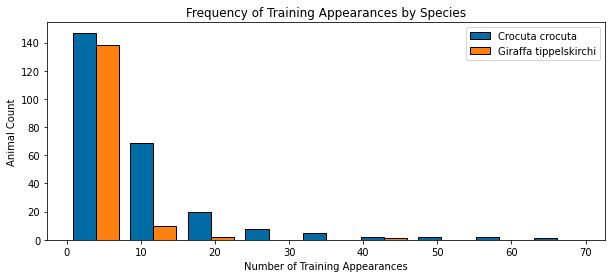

In [10]:
# Plot the counts of training appearances
bins = np.linspace(0, 70, 10)
plt.style.use('tableau-colorblind10')
figure(figsize=(10,4))
value, bins, bars = plt.hist(np.array([hyena_train_counts.animal_count.tolist(), giraffe_train_counts.animal_count.tolist()], dtype=object), bins, label=['Crocuta crocuta', 'Giraffa tippelskirchi'],
                             edgecolor='black')
plt.legend(loc='upper right')
plt.xlabel('Number of Training Appearances')
plt.ylabel('Animal Count')
plt.title('Frequency of Training Appearances by Species')
plt.show()

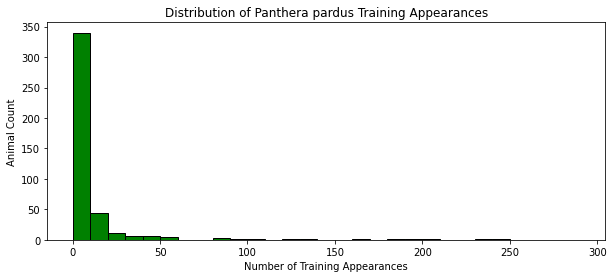

In [11]:
plt.style.use('tableau-colorblind10')
figure(figsize=(10,4))
plt.hist(np.array(leopard_train_counts.animal_count.tolist(), dtype=object), bins=range(0,300,10),color='green', edgecolor='black')
plt.xlabel('Number of Training Appearances')
plt.ylabel('Animal Count')
plt.title('Distribution of Panthera pardus Training Appearances')
plt.show()

In [12]:
def generate_embeddings(model, device, dl):
    """Return the embeddings and labels from the pretrained model backbone for all images in the dataloader"""
    embeddings = []
    labels = []
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for im, label in dl:
          im = im.to(device)
          embed = model(im).flatten(start_dim=1)
          embeddings.append(embed)
          labels.append(label)
    embeddings = torch.cat(embeddings, 0)
    embeddings = embeddings.cpu()
    embeddings = normalize(embeddings)
    embeddings = np.array(embeddings)
    labels = np.array([x.item() for x in labels])
    return embeddings, labels

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Define a transformation pipeline to be used to generate the embeddings
class_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229,0.224,0.225]),
        ])

In [15]:
class CustomDataset(Dataset):
    """A custom class to create the transformed datasets"""
    
    def __init__(self, root, folder, transform, mappings=None):
        super().__init__()
        # The path to the root directory and the specific folder in it
        self.root = root
        self.folder = folder
        # The images to be included
        self.img_dir = glob.glob(os.path.join(self.root, self.folder)+'/*/*.jpg')
        
        # Get the unique animal identifiers
        self.animal_ids = self._get_animal_ids()
        
        if mappings:
            # Create the mapping of animal string ids to integer values, using the passed mappings
            # the passed mappings will be the same as the one produced by the training set
            self.class_to_idx = mappings
        else:
            # Create a list of integers for the labels
            self.animal_int_labels = [x for x in range(len(self.animal_ids))]
            self.class_to_idx = dict(zip(self.animal_ids, self.animal_int_labels))
        
        # Define the preprocessing function
        self.transform = transform
    
    def _get_animal_ids(self):
        """Create a set of unique animal ids in string form"""
        animal_ids = os.listdir(self.root)
        return list(animal_ids)
            
    def __len__(self):
        return len(self.img_dir)
    
    def __getiteminternal__(self, idx):
        # Get the path to the image
        img_path = self.img_dir[idx]
        im = Image.open(img_path).convert('RGB')
        new_im = self.transform(im)
        # Get the animal name from the full path
        animal_name = img_path.split('/')[-2]
        label = self.class_to_idx[animal_name]
        # Return the two processed versions of the input image and a dummy label
        return new_im, label
    
    def __getitem__(self, idx):
        return self.__getiteminternal__(idx)

In [16]:
# Create the custom datasets of validation images for each species
hyena_data_dict = load('/content/drive/My Drive/individual_rec_models/individ_rec_modelsandhelpers/hyena_id_map.joblib')
# Swap the keys and values in the name map to enable looking up the string ids
hyena_res = dict((v,k) for k,v in hyena_data_dict.items())

leopard_data_dict = load('/content/drive/My Drive/individual_rec_models/individ_rec_modelsandhelpers/leopard_id_map.joblib')
# Swap the keys and values in the name map to enable looking up the string ids
leopard_res = dict((v,k) for k,v in leopard_data_dict.items())

giraffe_data_dict = load('/content/drive/My Drive/individual_rec_models/individ_rec_modelsandhelpers/giraffe_id_map.joblib')
# Swap the keys and values in the name map to enable looking up the string ids
giraffe_res = dict((v,k) for k,v in giraffe_data_dict.items())

In [17]:
# Create the custom datasets of hyena, leopard, and giraffe test images
hyena_test_ds = CustomDataset('/content/drive/My Drive/hyena.coco/processed/', 'test', transform=class_transform, mappings=hyena_res)
leopard_test_ds = CustomDataset('/content/drive/My Drive/leopard.coco/processed/', 'test', transform=class_transform, mappings=leopard_res)
giraffe_test_ds = CustomDataset('/content/drive/My Drive/great_zebra_giraffe/individual_recognition/', 'test', transform=class_transform, mappings=giraffe_res)

In [18]:
# Create dataloader objects for each species
hyena_test_dl = DataLoader(hyena_test_ds, batch_size=1, num_workers=2, shuffle=False)
leopard_test_dl = DataLoader(leopard_test_ds, batch_size=1, num_workers=2, shuffle=False)
giraffe_test_dl = DataLoader(giraffe_test_ds, batch_size=1, num_workers=2, shuffle=False)

In [19]:
# Get the embeddings and labels for all of the test sets
hyena_test_embeddings, hyena_test_labels = generate_embeddings(backbone_new, device, hyena_test_dl)
leopard_test_embeddings, leopard_test_labels = generate_embeddings(backbone_new, device, leopard_test_dl)
giraffe_test_embeddings, giraffe_test_labels = generate_embeddings(backbone_new, device, giraffe_test_dl)

In [20]:
# Load the pickled species specific KNN pipeline classifiers
hyena_knn_pipe = load('/content/drive/My Drive/individual_rec_models/individ_rec_modelsandhelpers/Crocuta_crocuta_knn.joblib')
leopard_knn_pipe = load('/content/drive/My Drive/individual_rec_models/individ_rec_modelsandhelpers/Panthera_pardus_knn.joblib')
giraffe_knn_pipe = load('/content/drive/My Drive/individual_rec_models/individ_rec_modelsandhelpers/Giraffa_tippelskirchi_knn.joblib')

In [42]:
# Get the top 1 accuracy scores of each validation set
hyena_test_preds = hyena_knn_pipe.predict(hyena_test_embeddings)
leopard_test_preds = leopard_knn_pipe.predict(leopard_test_embeddings)
giraffe_test_preds = giraffe_knn_pipe.predict(giraffe_test_embeddings)

print(f'Hyena test accuracy score: {accuracy_score(hyena_test_preds, hyena_test_labels)}')
print(f'Leopard test accuracy score: {accuracy_score(leopard_test_preds, leopard_test_labels)}')
print(f'Giraffe test accuracy score: {accuracy_score(giraffe_test_preds, giraffe_test_labels)}')

Hyena test accuracy score: 0.42628205128205127
Leopard test accuracy score: 0.6196136701337296
Giraffe test accuracy score: 0.5806451612903226


In [22]:
# Let's find out where the model is making mistakes
hyena_df = pd.DataFrame({'img_paths': hyena_test_ds.img_dir, 'label': hyena_test_labels, 'predictions': hyena_test_preds})
leopard_df = pd.DataFrame({'img_paths': leopard_test_ds.img_dir, 'label': leopard_test_labels, 'predictions': leopard_test_preds})
giraffe_df = pd.DataFrame({'img_paths': giraffe_test_ds.img_dir, 'label': giraffe_test_labels, 'predictions': giraffe_test_preds})

In [23]:
# Make training dataframes of the image paths and then find the counts of the number of times each animal was seen
hyena_train_df = pd.DataFrame({'img_paths': glob.glob('/content/drive/My Drive/hyena.coco/processed/train/*/*')})
leopard_train_df = pd.DataFrame({'img_paths': glob.glob('/content/drive/My Drive/leopard.coco/processed/train/*/*')})
giraffe_train_df = pd.DataFrame({'img_paths': glob.glob('/content/drive/My Drive/great_zebra_giraffe/individual_recognition/train/*/*')})

In [24]:
# For each training image, add a column for the individual animal name
hyena_train_df['animal_id'] = hyena_train_df.apply(lambda x: x['img_paths'].split('/')[-2], axis=1)
hyena_train_df['label'] = hyena_train_df.apply(lambda x: hyena_res.get(x['animal_id']), axis=1)

leopard_train_df['animal_id'] = leopard_train_df.apply(lambda x: x['img_paths'].split('/')[-2], axis=1)
leopard_train_df['label'] = leopard_train_df.apply(lambda x: leopard_res.get(x['animal_id']), axis=1)

giraffe_train_df['animal_id'] = giraffe_train_df.apply(lambda x: x['img_paths'].split('/')[-2], axis=1)
giraffe_train_df['label'] = giraffe_train_df.apply(lambda x: giraffe_res.get(x['animal_id']), axis=1)

In [25]:
# Import the training counts of the true and predicted labels
hyena_train_counts = pd.DataFrame(pd.DataFrame(hyena_train_df['label'].value_counts()).reset_index())
hyena_train_counts = hyena_train_counts.rename(columns={'label': 'train_count', 'index': 'label'})
hyena_df = hyena_df.merge(hyena_train_counts, on='label', how='left')

hyena_df = hyena_df.rename(columns={'train_count': 'true_label_train_count'})
# Rejoin to add the count of the train frequency of the predicted label
hyena_df = hyena_df.merge(hyena_train_counts, left_on='predictions', right_on='label')

hyena_df = hyena_df.rename(columns={'label_x': 'label', 'train_count': 'predicted_label_train_count'})
hyena_df = hyena_df.drop(columns='label_y')

In [26]:
# Import the training counts of the true and predicted labels
leopard_train_counts = pd.DataFrame(pd.DataFrame(leopard_train_df['label'].value_counts()).reset_index())
leopard_train_counts = leopard_train_counts.rename(columns={'label': 'train_count', 'index': 'label'})
leopard_df = leopard_df.merge(leopard_train_counts, on='label', how='left')

leopard_df = leopard_df.rename(columns={'train_count': 'true_label_train_count'})
# Rejoin to add the count of the train frequency of the predicted label
leopard_df = leopard_df.merge(leopard_train_counts, left_on='predictions', right_on='label')

leopard_df = leopard_df.rename(columns={'label_x': 'label', 'train_count': 'predicted_label_train_count'})
leopard_df = leopard_df.drop(columns='label_y')

In [27]:
# Import the training counts of the true and predicted labels
giraffe_train_counts = pd.DataFrame(pd.DataFrame(giraffe_train_df['label'].value_counts()).reset_index())
giraffe_train_counts = giraffe_train_counts.rename(columns={'label': 'train_count', 'index': 'label'})
giraffe_df = giraffe_df.merge(giraffe_train_counts, on='label', how='left')

giraffe_df = giraffe_df.rename(columns={'train_count': 'true_label_train_count'})
# Rejoin to add the count of the train frequency of the predicted label
giraffe_df = giraffe_df.merge(giraffe_train_counts, left_on='predictions', right_on='label')

giraffe_df = giraffe_df.rename(columns={'label_x': 'label', 'train_count': 'predicted_label_train_count'})
giraffe_df = giraffe_df.drop(columns='label_y')

In [28]:
# Filter the dataframes for where the models make mistakes
hyena_incorrect = hyena_df[hyena_df.label != hyena_df.predictions]
leopard_incorrect = leopard_df[leopard_df.label != leopard_df.predictions]
giraffe_incorrect = giraffe_df[giraffe_df.label != giraffe_df.predictions]

In [29]:
# Get the proportion of test set images where the individual had > 10 training images
print(f'{"{:.3%}".format(len(hyena_df[hyena_df.true_label_train_count > 10])/len(hyena_df))} of hyena test images belonged to animals with >10 training images')
print(f'{"{:.3%}".format(len(leopard_df[leopard_df.true_label_train_count > 10])/len(leopard_df))} of leopard test images belonged to animals with >10 training images')
print(f'{"{:.3%}".format(len(giraffe_df[giraffe_df.true_label_train_count > 10])/len(giraffe_df))} of giraffe test images belonged to animals with >10 training images')

51.603% of hyena test images belonged to animals with >10 training images
78.752% of leopard test images belonged to animals with >10 training images
17.742% of giraffe test images belonged to animals with >10 training images


In [30]:
# Get the accuracy scores for >10 training images by species
hyena_gtr_10 = hyena_df[hyena_df.true_label_train_count > 10]
print(f'The top-1 accuracy score is {"{:.3%}".format(accuracy_score(hyena_gtr_10.predictions.tolist(), hyena_gtr_10.label.tolist()))} for hyenas with >10 training images')

leopard_gtr_10 = leopard_df[leopard_df.true_label_train_count > 10]
print(f'The top-1 accuracy score is {"{:.3%}".format(accuracy_score(leopard_gtr_10.predictions.tolist(), leopard_gtr_10.label.tolist()))} for leopards with >10 training images')

giraffe_gtr_10 = giraffe_df[giraffe_df.true_label_train_count > 10]
print(f'The top-1 accuracy score is {"{:.3%}".format(accuracy_score(giraffe_gtr_10.predictions.tolist(), giraffe_gtr_10.label.tolist()))} for giraffes with >10 training images')

The top-1 accuracy score is 67.081% for hyenas with >10 training images
The top-1 accuracy score is 72.075% for leopards with >10 training images
The top-1 accuracy score is 63.636% for giraffes with >10 training images


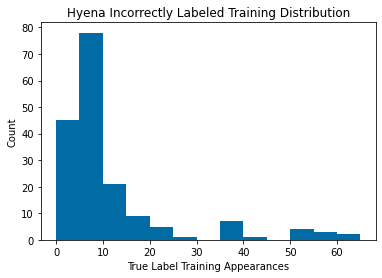

In [31]:
# Let's look at the training frequencies of the true label where the models make mistakes
hyena_incorrect['true_label_train_count'].hist(grid=False, bins=range(0,70,5))
plt.xlabel('True Label Training Appearances')
plt.ylabel('Count')
title = plt.title('Hyena Incorrectly Labeled Training Distribution')
title.set_color('black')

Text(0.5, 1.0, 'Hyena Incorrectly Labeled Training Distribution')

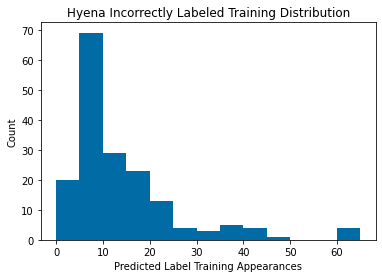

In [32]:
# Let's look at the training frequencies of the predicted label where the models make mistakes
hyena_incorrect['predicted_label_train_count'].hist(grid=False, bins=range(0,70,5))
plt.xlabel('Predicted Label Training Appearances')
plt.ylabel('Count')
plt.title('Hyena Incorrectly Labeled Training Distribution')

Text(0.5, 1.0, 'Leopard Incorrectly Labeled Training Distribution')

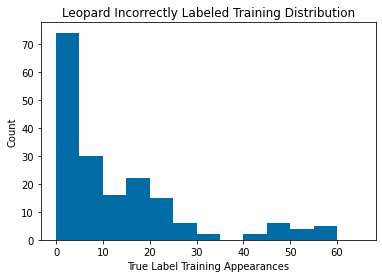

In [33]:
# Let's look at the training frequencies of the true label where the models make mistakes
leopard_incorrect['true_label_train_count'].hist(grid=False, bins=range(0,70,5))
plt.xlabel('True Label Training Appearances')
plt.ylabel('Count')
plt.title('Leopard Incorrectly Labeled Training Distribution')

Text(0.5, 1.0, 'Leopard Incorrectly Labeled Training Distribution')

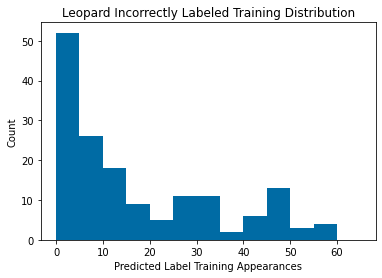

In [34]:
# Let's look at the training frequencies of the predicted label where the models make mistakes
leopard_incorrect['predicted_label_train_count'].hist(grid=False, bins=range(0,70,5))
plt.xlabel('Predicted Label Training Appearances')
plt.ylabel('Count')
plt.title('Leopard Incorrectly Labeled Training Distribution')

Text(0.5, 1.0, 'Giraffe Incorrectly Labeled Training Distribution')

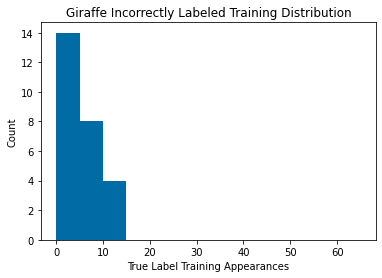

In [35]:
# Let's look at the training frequencies of the true label where the models make mistakes
giraffe_incorrect['true_label_train_count'].hist(grid=False, bins=range(0,70,5))
plt.xlabel('True Label Training Appearances')
plt.ylabel('Count')
plt.title('Giraffe Incorrectly Labeled Training Distribution')

Text(0.5, 1.0, 'Giraffe Incorrectly Labeled Training Distribution')

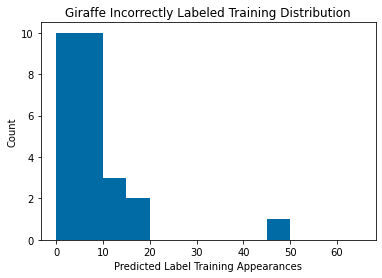

In [36]:
# Let's look at the training frequencies of the predicted label where the models make mistakes
giraffe_incorrect['predicted_label_train_count'].hist(grid=False, bins=range(0,70,5))
plt.xlabel('Predicted Label Training Appearances')
plt.ylabel('Count')
plt.title('Giraffe Incorrectly Labeled Training Distribution')

In [37]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

In [38]:
# Get the weighted precision and recall for each species
hyenas = spark.createDataFrame(hyena_df)
leopards = spark.createDataFrame(leopard_df)
giraffes = spark.createDataFrame(giraffe_df)

hyenas = hyenas.withColumn('label', col('label').cast(DoubleType())).withColumn('predictions', col('predictions').cast(DoubleType()))
leopards = leopards.withColumn('label', col('label').cast(DoubleType())).withColumn('predictions', col('predictions').cast(DoubleType()))
giraffes = giraffes.withColumn('label', col('label').cast(DoubleType())).withColumn('predictions', col('predictions').cast(DoubleType()))

In [39]:
evaluator = MulticlassClassificationEvaluator()
evaluator.setPredictionCol("predictions")

print(evaluator.evaluate(hyenas, {evaluator.metricName: "weightedPrecision"}))
print(evaluator.evaluate(hyenas, {evaluator.metricName: "weightedRecall"}), sep='/n')
print(evaluator.evaluate(leopards, {evaluator.metricName: "weightedPrecision"}))
print(evaluator.evaluate(leopards, {evaluator.metricName: "weightedRecall"}), sep='/n')
print(evaluator.evaluate(giraffes, {evaluator.metricName: "weightedPrecision"}))
print(evaluator.evaluate(giraffes, {evaluator.metricName: "weightedRecall"}))

0.44109779109779085
0.4262820512820509
0.6131361520058631
0.619613670133729
0.7365591397849459
0.5806451612903223


In [40]:
# Load the dataframe of the images in common with the other capstone team
shared_test = pd.read_csv('/content/drive/My Drive/individual_rec_models/matches_test_sets.csv')
trial = shared_test[(shared_test.in_test == True) & (shared_test.both_testsets == True)]

In [41]:
# Make a dataframe from the test predictions, the test images, and the actual predictions and filter the test dataset for images also used by the other capstone team
leopard_test_df = pd.DataFrame({'img_path': leopard_test_ds.img_dir, 'label': leopard_test_labels, 'predictions': leopard_test_preds})
leopard_test_df['img_name'] = leopard_test_df.apply(lambda x: x['img_path'].split('/')[-1], axis=1)
trial_imgs = trial['stripped'].tolist()
leopard_test_df['compete_img'] = leopard_test_df.apply(lambda x: x['img_name'] in trial_imgs, axis=1)
check = leopard_test_df[leopard_test_df.compete_img == True]

# Find the top 1 accuracy score for the images used in the test set of both capstone teams
accuracy_score(check.predictions.tolist(), check.label.tolist())

0.5538461538461539